In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from python_code.parabolaRansac import parabolaRansac
from python_code.ransacLocalization import ransacLocalization
from python_code.code_previous_exercises.describeKeypoints import describeKeypoints
from python_code.code_previous_exercises.harris import harris
from python_code.code_previous_exercises.matchDescriptors import matchDescriptors
from python_code.code_previous_exercises.selectKeypoints import selectKeypoints
from python_code.code_previous_exercises.plotMatches import plotMatches
from python_code.code_previous_exercises.draw_camera import drawCamera

In [2]:
# Create data for parts 1 and 2
num_inliers = 20
num_outliers = 10
noise_ratio = 0.1
poly = np.random.uniform(size=[3, 1])  # random second-order polynomial
extremum = -poly[1]/(2*poly[0])
xstart = extremum - 0.5
lowest = np.polyval(poly, extremum)
highest = np.polyval(poly, xstart)
xspan = 1
yspan = highest - lowest
max_noise = noise_ratio * yspan
x = np.random.uniform(size=[1, num_inliers]) + xstart
y = np.polyval(poly, x)
y = y + (np.random.uniform(size=y.shape) - 0.5) * 2 * max_noise
data = np.concatenate([np.concatenate([x, np.random.uniform(size=[1, num_outliers]) + xstart], axis=1),
                       np.concatenate([y, np.random.uniform(size=[1, num_outliers]) * yspan + lowest], axis=1)], axis=0)

# Data for parts 3 and 4
K = np.loadtxt('./data/K.txt')
keypoints = np.loadtxt('./data/keypoints.txt').T
p_W_landmarks = np.loadtxt('./data/p_W_landmarks.txt')

# Data for part 4
database_image = cv2.imread('./data/000000.png', cv2.IMREAD_GRAYSCALE)


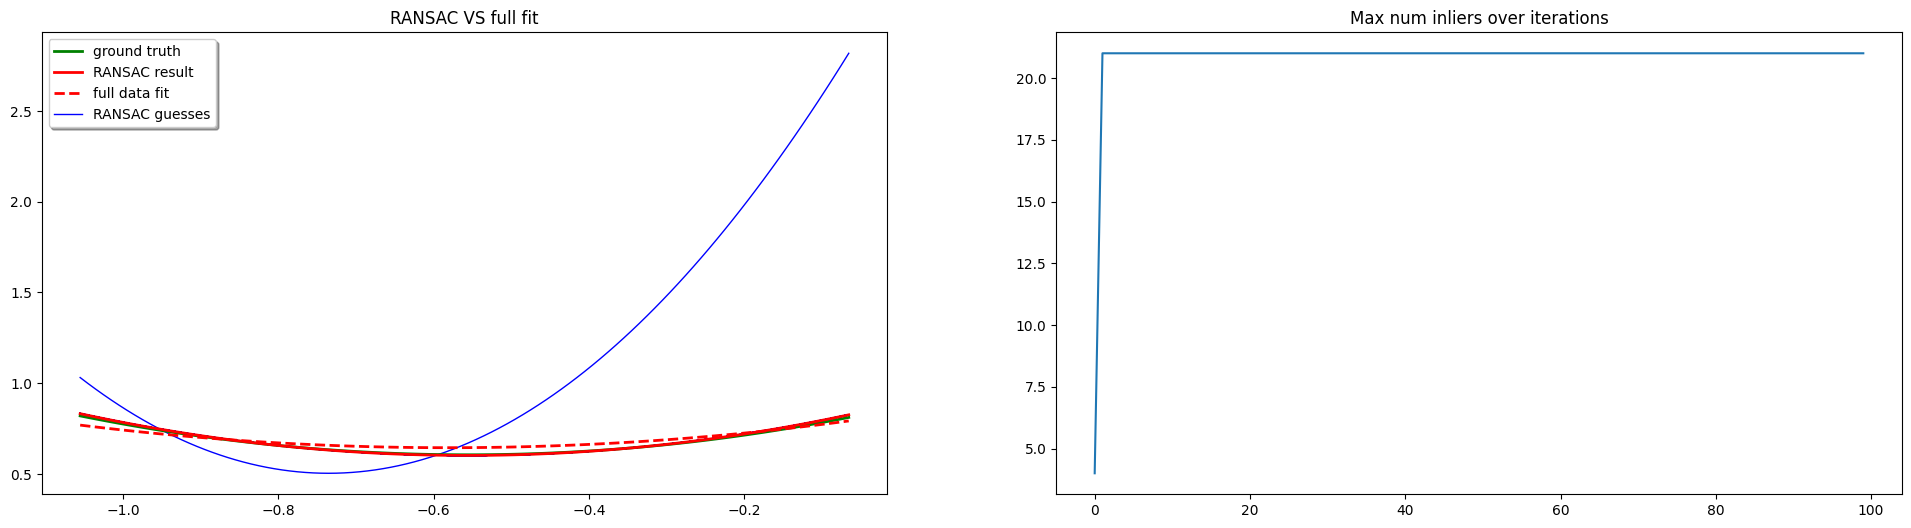

RMS of full fit =
0.02813857401461302
RMS of RANSAC =
0.005596046728176163


In [3]:
# Part 1 - RANSAC with parabola model
best_guess_history, max_num_inliers_history = parabolaRansac(data, max_noise)

# Compare with full data fit.
full_fit = np.polyfit(data[0, :], data[1, :], 2)


fig, axs = plt.subplots(1, 2, figsize=(24,6))

x = np.arange(xstart, xstart+1, 0.01)
for i in range(best_guess_history.shape[1]):
    guess_plot = axs[0].plot(x, np.polyval(best_guess_history[:, i], x), c='b', linewidth=1)

axs[0].plot(x, np.polyval(poly, x), 'g', linewidth=2, label='ground truth')
axs[0].plot(x, np.polyval(best_guess_history[:, -1], x), 'r', linewidth=2, label='RANSAC result')
axs[0].plot(x, np.polyval(full_fit, x), 'r--', linewidth=2, label='full data fit')
axs[0].set_title('RANSAC VS full fit')


line = Line2D([0], [0], color='b', linewidth=1, linestyle='-', label='RANSAC guesses')
handles, labels = axs[0].get_legend_handles_labels()
handles.append(line)
axs[0].legend(handles=handles, shadow=True, fancybox=True)

axs[1].plot(max_num_inliers_history)
axs[1].set_title('Max num inliers over iterations')
plt.show()

print('RMS of full fit =')
x = np.arange(0, 1, 0.01) + xstart
print(np.sqrt(np.mean(np.square(np.polyval(poly, x) - np.polyval(full_fit, x)))))
print('RMS of RANSAC =')
x = np.arange(0, 1, 0.01) + xstart
print(np.sqrt(np.mean(np.square(np.polyval(poly, x) - np.polyval(best_guess_history[:, -1], x)))))


    Adaptive RANSAC: Needed 10 iteration to converge.
    Adaptive RANSAC: Estimated Ouliers: 36.885245901639344 %
Found transformation T_C_W = 
[[ 9.99993581e-01  2.37803666e-03  2.68015683e-03  7.82068964e-03]
 [-2.37949880e-03  9.99997022e-01  5.42485797e-04  1.16437471e-02]
 [-2.67885880e-03 -5.48859745e-04  9.99996261e-01 -7.06518241e-01]]
Estimated inlier ratio is
0.6311475409836066


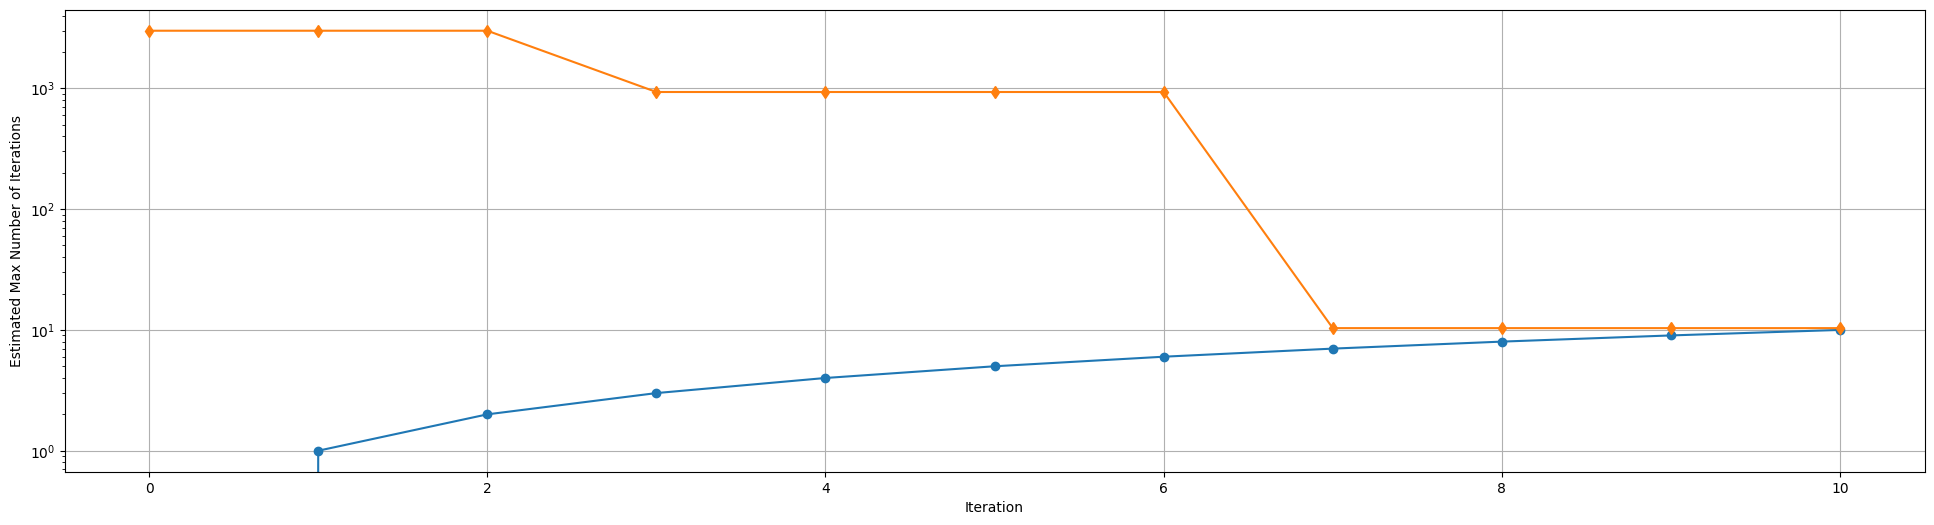

In [6]:
# Parts 2 and 3 - Localization with RANSAC + DLT/P3P
query_image = cv2.imread('./data/000001.png', cv2.IMREAD_GRAYSCALE)

# Parameters from exercise 3.
harris_patch_size = 9
harris_kappa = 0.08
nonmaximum_supression_radius = 8
descriptor_radius = 9
match_lambda = 5

# Other parameters
num_keypoints = 1000

# Detect and match keypoints.
database_keypoints = keypoints
query_harris = harris(query_image, harris_patch_size, harris_kappa)
query_keypoints = selectKeypoints(query_harris, num_keypoints, nonmaximum_supression_radius)
query_descriptors = describeKeypoints(query_image, query_keypoints, descriptor_radius)
database_descriptors = describeKeypoints(database_image, database_keypoints, descriptor_radius)
all_matches = matchDescriptors(query_descriptors, database_descriptors, match_lambda)

# Drop unmatched keypoints and get 3d landmarks for the matched ones.
matched_query_keypoints = query_keypoints[:, all_matches >= 0]
corresponding_matches = all_matches[all_matches >= 0]
corresponding_landmarks = p_W_landmarks[corresponding_matches, :]

# perform RANSAC to find best Pose and inliers
out = ransacLocalization(matched_query_keypoints, corresponding_landmarks, K)
R_C_W, t_C_W, inlier_mask, max_num_inliers_history, num_iteration_history = out

print('Found transformation T_C_W = ')
print(np.concatenate([R_C_W, t_C_W[:, None]], axis=-1))
print('Estimated inlier ratio is')
print(inlier_mask.mean())

matched_query_keypoints = query_keypoints[:, all_matches >= 0]
corresponding_matches = all_matches[all_matches >= 0]

plt.figure(figsize=(24,6))
plt.plot(np.arange(len(num_iteration_history)), "-o")
plt.plot(num_iteration_history, "-d")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Estimated Max Number of Iterations")
plt.grid()
plt.show()

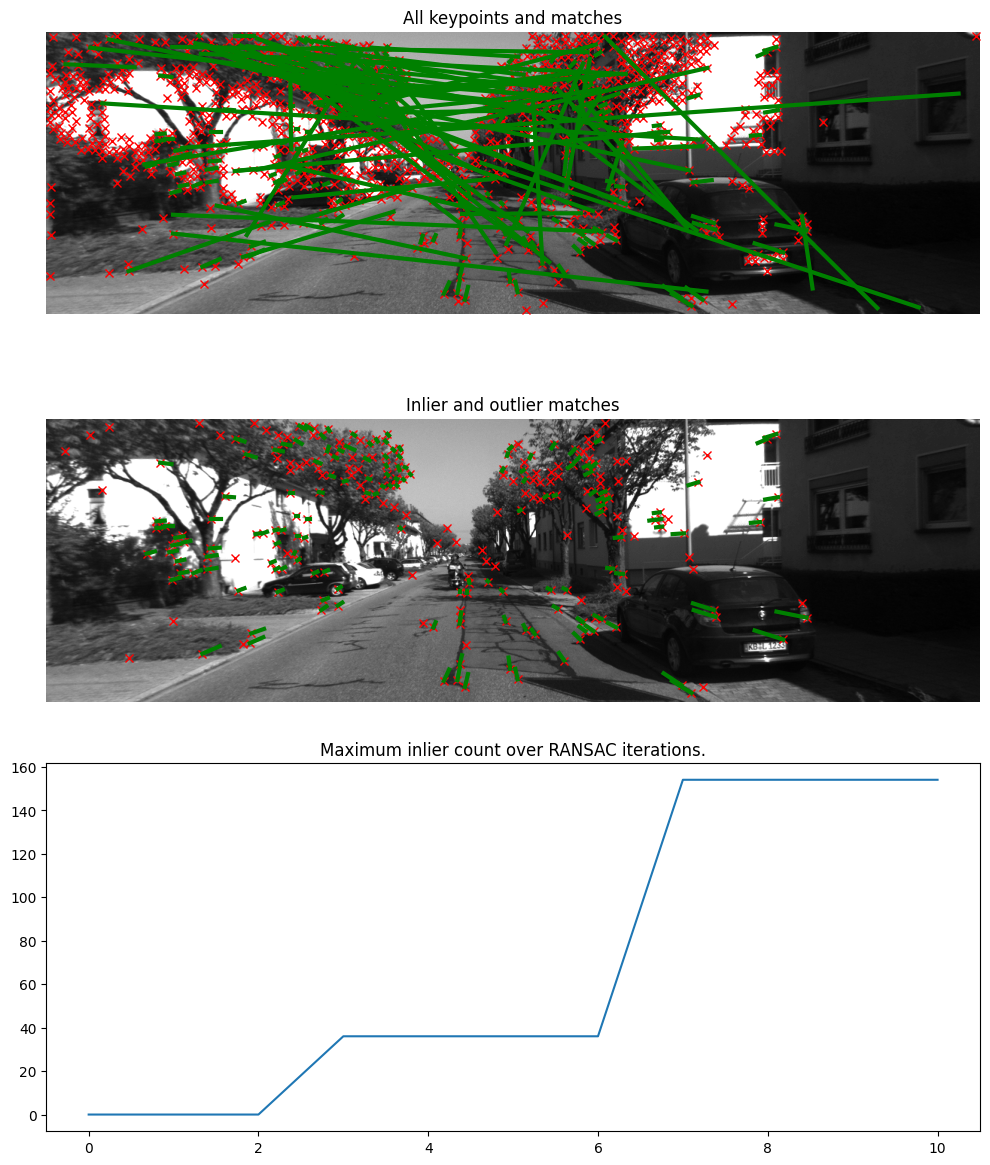

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(10,12))
axs[0].imshow(query_image, cmap='gray')
axs[0].plot(query_keypoints[1, :], query_keypoints[0, :], 'rx', linewidth=2)
plotMatches(all_matches, query_keypoints, keypoints, axs[0])
axs[0].set_title('All keypoints and matches')
axs[0].axis('off')

axs[1].imshow(query_image, cmap='gray')
axs[1].plot(matched_query_keypoints[1, np.logical_not(inlier_mask)], matched_query_keypoints[0, np.logical_not(inlier_mask)],
            'rx', linewidth=2)
axs[1].plot(matched_query_keypoints[1, inlier_mask], matched_query_keypoints[0, inlier_mask], 'rx', linewidth=2)
plotMatches(corresponding_matches[inlier_mask], matched_query_keypoints[:, inlier_mask], keypoints, axs[1])
axs[1].set_title('Inlier and outlier matches')
axs[1].axis('off')

axs[2].plot(max_num_inliers_history)
axs[2].set_title('Maximum inlier count over RANSAC iterations.')

plt.tight_layout()
plt.show()

In [10]:
fig = plt.figure()

for i in range(9):
    fig.clear()
    query_image = cv2.imread('./data/{0:06d}.png'.format(i), cv2.IMREAD_GRAYSCALE)

    # Detect and match keypoints
    database_keypoints = keypoints
    query_harris = harris(query_image, harris_patch_size, harris_kappa)
    query_keypoints = selectKeypoints(query_harris, num_keypoints, nonmaximum_supression_radius)
    query_descriptors = describeKeypoints(query_image, query_keypoints, descriptor_radius)
    database_descriptors = describeKeypoints(database_image, database_keypoints, descriptor_radius)
    all_matches = matchDescriptors(query_descriptors, database_descriptors, match_lambda)

    # Drop unmatched keypoints and get 3d landmarks for the matched ones.
    matched_query_keypoints = query_keypoints[:, all_matches >= 0]
    corresponding_matches = all_matches[all_matches >= 0]
    corresponding_landmarks = p_W_landmarks[corresponding_matches, :]

    # perform RANSAC to find best Pose and inliers
    out = ransacLocalization(matched_query_keypoints, corresponding_landmarks, K)
    R_C_W, t_C_W, inlier_mask, max_num_inliers_history, num_iteration_history = out

    ax = fig.add_subplot(2, 1, 1)
    ax.imshow(query_image, cmap='gray')
    ax.plot(matched_query_keypoints[1, np.logical_not(inlier_mask)],
                matched_query_keypoints[0, np.logical_not(inlier_mask)],
                'rx', linewidth=2)
    if inlier_mask.sum() > 0:
        ax.plot(matched_query_keypoints[1, inlier_mask], matched_query_keypoints[0, inlier_mask], 'rx', linewidth=2)
        plotMatches(corresponding_matches[inlier_mask], matched_query_keypoints[:, inlier_mask], keypoints, ax)
    ax.set_title('Inlier and outlier matches')
    ax.axis('off')

    ax = fig.add_subplot(2, 1, 2, projection='3d')
    ax.set_xlim3d(-15, 10)
    ax.set_ylim3d(-10, 5)
    ax.set_zlim3d(-1, 40)
    ax.scatter(p_W_landmarks[:, 0], p_W_landmarks[:, 1], p_W_landmarks[:, 2], s=0.5)
    if R_C_W is not None:
        drawCamera(ax, -np.matmul(R_C_W.T, t_C_W), R_C_W.T, length_scale=10, head_size=10, set_ax_limits=True)
        print('Frame {} localized with {} inliers!'.format(i, inlier_mask.sum()))
    else:
        print('Frame {} failed to localize!'.format(i))

    plt.pause(1)

    Adaptive RANSAC: Needed 3 iteration to converge.
    Adaptive RANSAC: Estimated Ouliers: 18.827160493827154 %
Frame 0 localized with 263 inliers!


AttributeError: 'RendererAgg' object has no attribute 'M'

AttributeError: 'RendererAgg' object has no attribute 'M'

<Figure size 640x480 with 2 Axes>